In [1]:
import time

import tensorflow as tf
from tensorflow.contrib import rnn

import numpy as np
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 16)

print("Package is ready.")

ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/usr/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/usr/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libcudnn.so.6: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [2]:
# Load them!
l = np.load("./Data/ECtrainset_wRWEC.npz")

# See what's in here
print (l.files)

# get data
train_data = l['traindataset']
train_label = l['trainlabel']
test_data = l['testdataset']
test_label = l['testlabel']

mins = l['mins']
maxs = l['maxs']

labelmins = l['labelmins']
labelmaxs = l['labelmaxs']

explanation = "RWEC_multi_LSTM"
DELETE = [4,5,11,12]
EX_PRED = 0.671604 #Sorry, it's not automated yet.

train_data = np.delete(train_data, DELETE, axis=1)
test_data = np.delete(test_data, DELETE, axis=1)
train_label = train_label[:,:]
test_label = test_label[:,:]

print(train_data[:5])
print(train_label[:5])
print(test_data[:5])
print(test_label[:5])

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

['maxs', 'trainlabel', 'testdataset', 'mins', 'labelmaxs', 'labelmins', 'traindataset', 'testlabel']
[[ 0.32567992  0.50084235  0.20491604  0.48089765  0.92516063  0.78223629
   0.55528701  0.42583577  0.06756757  0.1855959   0.48086426  0.36363636
   0.52895695  0.14888828  0.23222229  0.24793388]
 [ 0.33018636  0.48709495  0.25655674  0.26491767  0.92931601  0.82019292
   0.45507889  0.35457283  0.06756757  0.23956612  0.26476511  0.36363636
   0.58277116  0.07926687  0.23222229  0.30664601]
 [ 0.32754387  0.39184369  0.24740103  0.480947    0.904194    0.83032818
   0.55135952  0.43005518  0.06756757  0.2554854   0.48090275  0.36363636
   0.64832338  0.03440592  0.23222229  0.30991736]
 [ 0.32294789  0.37715523  0.25419894  0.49524414  0.89576271  0.80197632
   0.55135952  0.43005518  0.06756757  0.2554854   0.49513653  0.36363636
   0.68042326  0.          0.23222229  0.30991736]
 [ 0.32487844  0.37766854  0.2574289   0.51254409  0.90079292  0.7841957
   0.55135952  0.43005518  0.0

In [3]:
#Data setting
n_train = train_label.shape[0]
n_test = test_label.shape[0]
n_input = train_data.shape[1]
n_output = test_label.shape[1]
n_classes = n_output

print("# train: %d # test: %d, # input: %d, # output: %d" % (n_train, n_test, n_input, n_output))


# train: 1200 # test: 456, # input: 16, # output: 18


In [4]:
# Parameters
learning_rate = 0.001
training_epochs = 10000
batch_size = n_train
display_step = 500

# Network Parameters
n_steps = 30 # 1.5 day
n_hidden = 64 # hidden layer num of features
n_layers = 4

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_output])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output]))
}

print("parameters are ready")

parameters are ready


In [5]:
# Load them!
l = np.load("./Data/ECpredset_wRWEC.npz")

# See what's in here
print (l.files)

# get data
pred_data = l['preddataset']
pred_label = l['predlabel']
n_pred = pred_label.shape[0]

print(pred_data[0])
print(pred_label[0])

print(pred_data.shape)
print(pred_label.shape)

#Processing

for i in range(pred_data.shape[1]):
    temp = pred_data[:,i]
    temp = (temp - mins[i]) / (maxs[i] - mins[i])
    pred_data[:,i] = temp

    
for i in range(pred_label.shape[1]):
    temp = pred_label[:,i]
    temp = (temp - labelmins[i]) / (labelmaxs[i] - labelmins[i])
    pred_label[:,i] = temp
    
pred_data = np.delete(pred_data, DELETE, axis=1)

pred_x = pred_data.reshape((-1, n_steps, n_input))

['predlabel', 'preddataset']
[   4.509825      2.36598889    3.63195556   16.15047222   19.63758333
   13.21697222   67.13763889    4.470975      1.768         1.382         0.
    6.36231111    4.28258333    5.374425      5.23260278  150.
  408.34777778    0.           30.           12.355     ]
[ 4.48515278  4.46378611  4.44831667  4.42421667  4.40596667  4.37809167
  4.58665556  4.85048889  4.90490833  4.97277778  4.90884722  4.83730833
  4.75139167  4.71204167  4.66605556  4.62548056  4.5976      4.554325  ]
(3600, 20)
(120, 18)


In [6]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    
    lstm_cells = rnn.MultiRNNCell([rnn.LSTMCell(n_hidden, forget_bias=1.0) for _ in range(n_layers)])
    
    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cells, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

print("network is ready")

network is ready


In [7]:
# Define loss and optimizer
cost = tf.multiply(tf.reduce_sum(tf.square(tf.subtract(pred, y))),1/batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
ymean = tf.reduce_mean(y)
SSE = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
SSR = tf.reduce_sum(tf.square(tf.subtract(pred, ymean)))
r_squared = SSR/(SSE+SSR)
                                
accuracy = r_squared
# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Do some optimizations
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(init)

print("seesion start")

seesion start


In [8]:
# Summary writer
tf.summary.scalar('RMS', cost)
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()
directory_name = "./tb_logs/" + explanation + str(n_hidden)
summary_writer = tf.summary.FileWriter(directory_name, graph=sess.graph)
print ("Summary ready")

Summary ready


In [9]:
# Launch the graph
num_data = train_data.shape[0]
ex_pred_acc = EX_PRED

# Keep training until reach max iterations
start = time.time()

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(num_data/batch_size/n_steps)

    for i in range(total_batch):
        batch_x = train_data[i:i+n_steps*batch_size, :]
        batch_y = train_label[i:i+batch_size, :]
        
        # Reshape data
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_x, y: batch_y})
        avg_cost += sess.run(cost, feed_dict={x: batch_x, y: batch_y})/total_batch
        summary_writer.add_summary(summary, epoch*total_batch+i)
        
        pred_acc = sess.run(accuracy, feed_dict={x: pred_x, y: pred_label})

    if pred_acc > ex_pred_acc:
        bestpath = "./models/best_trained_" + explanation + ".ckpt"
        save_path = saver.save(sess, bestpath)
        ex_pred_acc = pred_acc
        
    if epoch % display_step == 0:
        print ("Epoch: %04d/%04d cost: %.6f, best: %.3f" % (epoch, training_epochs, avg_cost,ex_pred_acc))
        train_acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})

        test_x = test_data.reshape((-1, n_steps, n_input))
        test_acc = sess.run(accuracy, feed_dict={x: test_x, y: test_label})
        pred_acc = sess.run(accuracy, feed_dict={x: pred_x, y: pred_label})
        print ("Training Acc: %.3f, Validation Acc: %.3f, Test Acc: %.3f" % (train_acc, test_acc, pred_acc))
        
            
print ("Epoch: %04d/%04d cost: %.6f" % (epoch+1, training_epochs, avg_cost))
train_acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})

test_x = test_data.reshape((-1, n_steps, n_input))
test_acc = sess.run(accuracy, feed_dict={x: test_x, y: test_label})
print ("Training Acc: %.3f, Validation Acc: %.3f, Test Acc: %.3f" % (train_acc, test_acc, pred_acc))

end = time.time() - start
print ("Optimization Finished\ntraining time: %.2f sec." % (end))

Epoch: 0000/10000 cost: 27.558317, best: 0.672
Training Acc: 0.493, Validation Acc: 0.493, Test Acc: 0.498
Epoch: 0500/10000 cost: 0.088571, best: 0.672
Training Acc: 0.874, Validation Acc: 0.874, Test Acc: 0.590
Epoch: 1000/10000 cost: 0.052771, best: 0.672
Training Acc: 0.924, Validation Acc: 0.916, Test Acc: 0.656
Epoch: 1500/10000 cost: 0.038854, best: 0.674
Training Acc: 0.945, Validation Acc: 0.936, Test Acc: 0.638
Epoch: 2000/10000 cost: 0.025311, best: 0.674
Training Acc: 0.964, Validation Acc: 0.955, Test Acc: 0.570
Epoch: 2500/10000 cost: 0.018133, best: 0.674
Training Acc: 0.974, Validation Acc: 0.965, Test Acc: 0.555
Epoch: 3000/10000 cost: 0.015640, best: 0.674
Training Acc: 0.977, Validation Acc: 0.970, Test Acc: 0.564
Epoch: 3500/10000 cost: 0.025256, best: 0.674
Training Acc: 0.963, Validation Acc: 0.959, Test Acc: 0.584
Epoch: 4000/10000 cost: 0.011652, best: 0.674
Training Acc: 0.983, Validation Acc: 0.977, Test Acc: 0.560
Epoch: 4500/10000 cost: 0.009580, best: 0.674

In [10]:
#Choose best model
saver.restore(sess, bestpath)
print("Model restored, best Acc: %.3f" % ex_pred_acc)

INFO:tensorflow:Restoring parameters from ./models/best_trained_RWEC_multi_LSTM.ckpt
Model restored, best Acc: 0.674


In [11]:
#Calculate accuracy for 128 mnist test images
print ("Testing Accuracy:", sess.run(accuracy, feed_dict={x: pred_x, y: pred_label}))

Testing Accuracy: 0.674302


In [12]:
estimation = sess.run(pred, feed_dict={x: test_x, y: test_label})
estimation.shape

(456, 18)

In [13]:
#Data restoring
for i in range(n_output):
    estimation[:,i] = (labelmaxs[i] - labelmins[i]) * estimation[:,i] + labelmins[i]
    test_label[:,i] = (labelmaxs[i] - labelmins[i]) * test_label[:,i] + labelmins[i]

print(estimation[:5])
print(test_label[:5])

[[ 3.68554068  3.71231484  3.81603909  3.8442421   3.83787775  3.88272405
   3.87713027  3.93284774  3.89243174  3.88989282  3.87327003  3.84104013
   3.83226037  3.82172847  3.80222249  3.77179766  3.7519927   3.7151258 ]
 [ 4.50101423  4.53639507  4.52388811  4.49734545  4.51931858  4.44537926
   4.4379468   4.41316557  4.36623907  4.42315435  4.41098404  4.44189167
   4.52521515  4.61392021  4.63178587  4.69688654  4.71760607  4.72975063]
 [ 3.91432953  3.89155817  3.87921977  3.89459229  3.85280609  3.83899331
   3.81999373  3.83217144  3.7879796   3.69224763  3.69699168  3.68627644
   3.67482352  3.59899211  3.62372398  3.66149092  3.62827349  3.73974538]
 [ 3.86630082  3.82579041  3.75420308  3.77873278  3.81320262  3.82560921
   3.87288117  3.92317486  4.02520084  4.04749393  4.1297226   4.15647888
   4.1557107   4.12477112  4.07910776  4.04999447  4.03928137  4.01219606]
 [ 4.13798428  4.11353207  4.09744215  4.08872128  4.02978468  4.00825596
   4.02333212  4.02175999  3.98145

In [14]:
valid_RMSE = np.sum(np.sqrt((test_label - estimation)**2))/(estimation.shape[0]*18)

print("valid RMSE: %.5f" % valid_RMSE)

valid RMSE: 0.07826


In [15]:
for i in range(test_label.shape[1]):
    print(i+1, r2_score(test_label[:, i], estimation[:, i]))

1 0.907117886613
2 0.885355655789
3 0.902069690177
4 0.888263748351
5 0.88934142802
6 0.904475040316
7 0.915090749524
8 0.915177489506
9 0.908600187033
10 0.920422272817
11 0.90544596224
12 0.907212264648
13 0.896989781422
14 0.901358513053
15 0.91013477106
16 0.908975287593
17 0.909901795386
18 0.904881945727


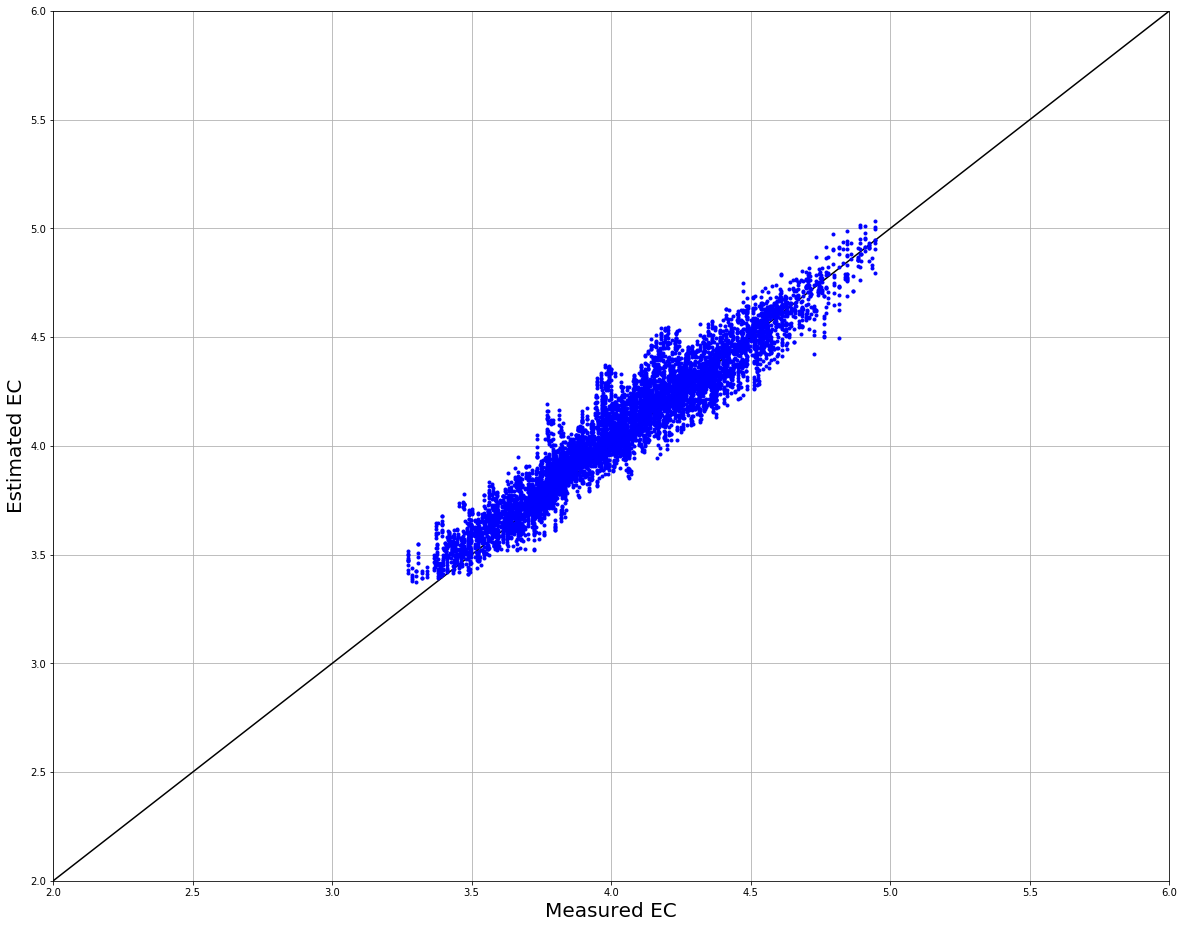

In [16]:
#1:1 graph
x_t = np.arange(-5, 10)
y_t = x_t

xny = plt.plot(x_t,y_t,'k')

expect1 = plt.plot(test_label, estimation, 'b.')

plt.axis([2, 6, 2, 6])
plt.grid(True)
plt.xlabel('Measured EC', {'fontsize':20})
plt.ylabel('Estimated EC',  {'fontsize':20})
#plt.legend([expect1], ["Mg"], prop={'size': 12})
plt.show()

In [17]:
regression_output = np.concatenate((test_label.T, estimation.T), axis=0).T

file_name = "regression_output_" + explanation + ".CSV"
np.savetxt("./Results/" + file_name, regression_output, delimiter=",")

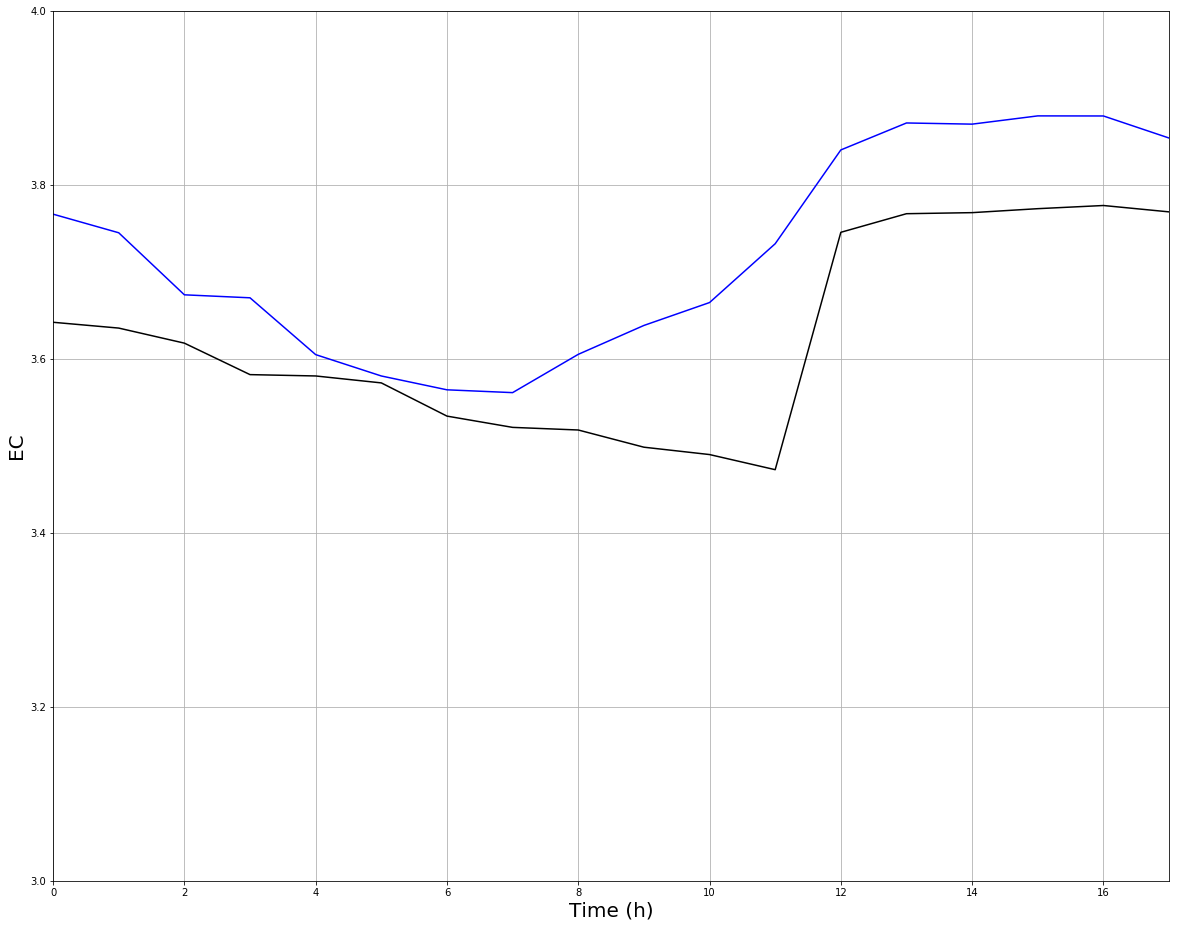

In [18]:
#chronological graph
x_t = np.arange(0, n_output)

measured1 = plt.plot(x_t, test_label[55,:].T, 'k') #estimated

expect1 = plt.plot(x_t, estimation[55,:].T, 'b') #estimated



plt.axis([0, n_output-1, 3, 4])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

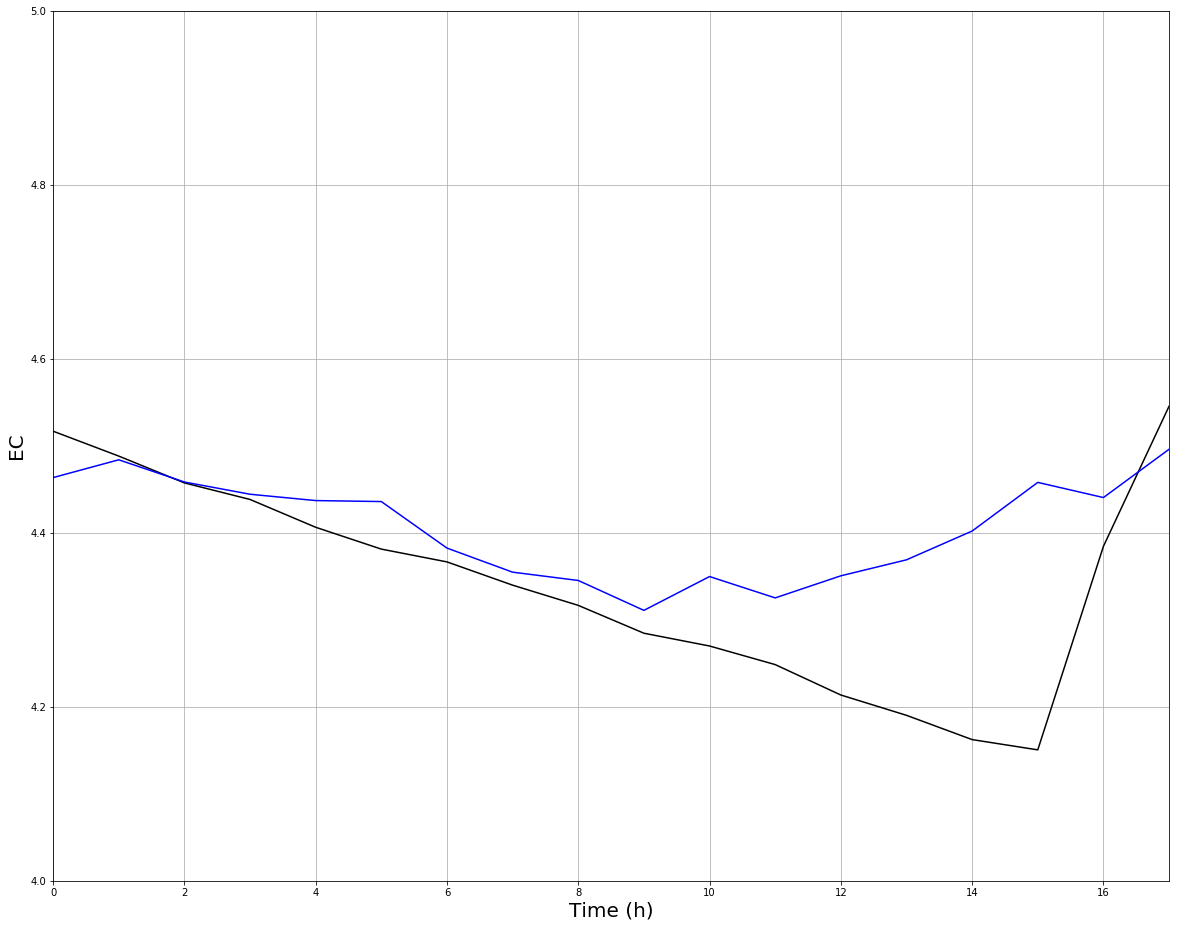

In [19]:
#chronological graph
i = 72
x_t = np.arange(0, n_output)

measured1 = plt.plot(x_t, test_label[i,:].T, 'k') #estimated

expect1 = plt.plot(x_t, estimation[i,:].T, 'b') #estimated



plt.axis([0, n_output-1, 4, 5])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

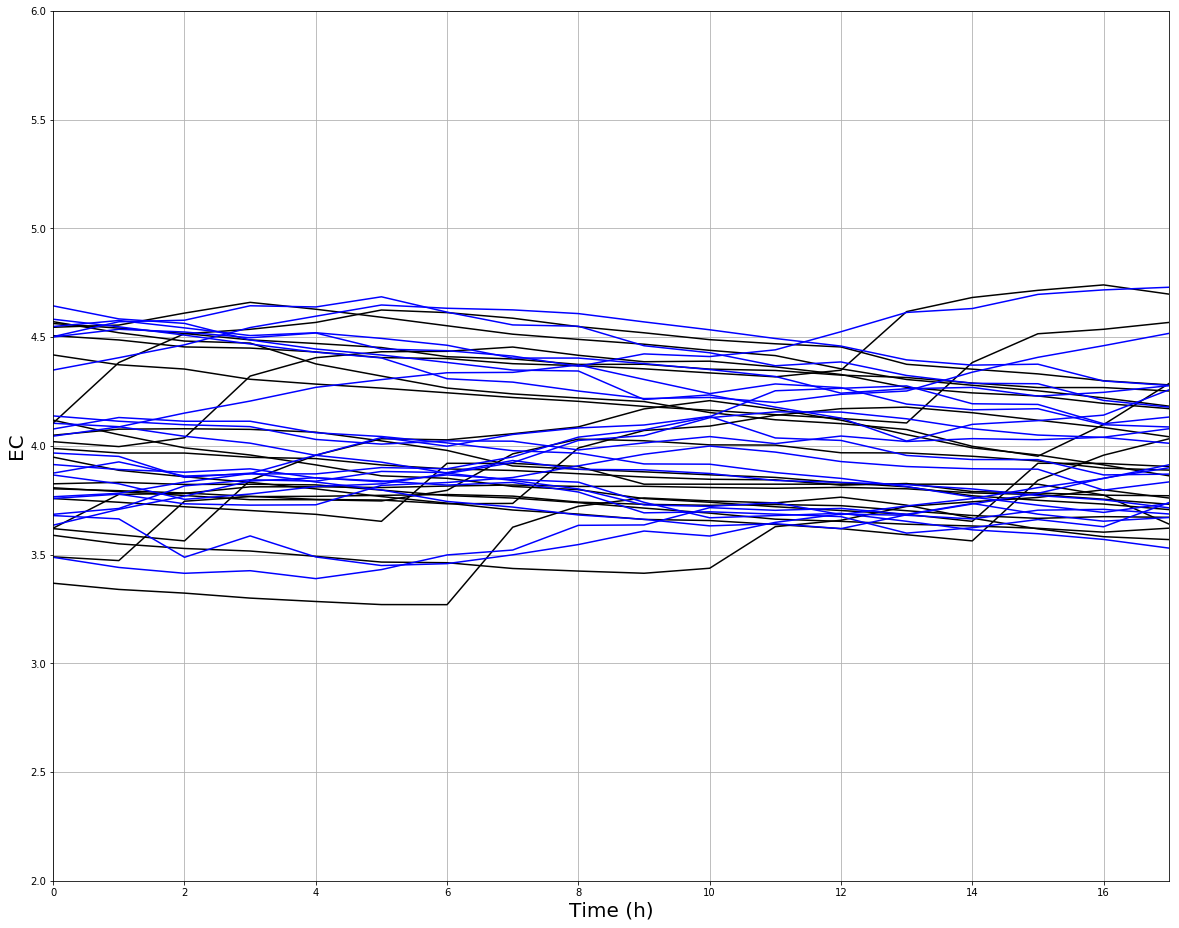

In [20]:
#chronological graph
x_t = np.arange(0, n_output)

measured1 = plt.plot(x_t, test_label[:20,:].T, 'k') #estimated
expect1 = plt.plot(x_t, estimation[:20,:].T, 'b') #estimated

plt.axis([0, n_output-1, 2, 6])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

In [21]:
# Load them!
l = np.load("./Data/ECpredset_wRWEC.npz")

# See what's in here
print (l.files)

# get data
pred_data = l['preddataset']
pred_label = l['predlabel']
n_pred = pred_label.shape[0]

print(pred_data[0])
print(pred_label[0])

print(pred_data.shape)
print(pred_label.shape)

['predlabel', 'preddataset']
[   4.509825      2.36598889    3.63195556   16.15047222   19.63758333
   13.21697222   67.13763889    4.470975      1.768         1.382         0.
    6.36231111    4.28258333    5.374425      5.23260278  150.
  408.34777778    0.           30.           12.355     ]
[ 4.48515278  4.46378611  4.44831667  4.42421667  4.40596667  4.37809167
  4.58665556  4.85048889  4.90490833  4.97277778  4.90884722  4.83730833
  4.75139167  4.71204167  4.66605556  4.62548056  4.5976      4.554325  ]
(3600, 20)
(120, 18)


In [22]:
#Processing

for i in range(pred_data.shape[1]):
    temp = pred_data[:,i]
    temp = (temp - mins[i]) / (maxs[i] - mins[i])
    pred_data[:,i] = temp

    
for i in range(pred_label.shape[1]):
    temp = pred_label[:,i]
    temp = (temp - labelmins[i]) / (labelmaxs[i] - labelmins[i])
    pred_label[:,i] = temp

In [23]:
pred_data = np.delete(pred_data, DELETE, axis=1)

In [24]:
print(pred_data[0])
print(pred_label[0])

[ 0.39660363  0.37346666  0.20244891  0.53094022  0.83060659  0.71674836
  0.53413897  0.44855566  0.06756757  0.21209254  0.53081761  0.36363636
  0.71393845  0.          0.23222229  0.24311295]
[ 0.72520933  0.7124582   0.70322641  0.68884409  0.67795292  0.66131778
  0.78578379  0.9432333   0.97570954  1.01621243  0.97806018  0.93536746
  0.88409442  0.86061126  0.83316784  0.80895364  0.79231518  0.76648968]


In [25]:
pred_label.shape

(120, 18)

In [26]:
pred_x = pred_data.reshape((-1, n_steps, n_input))

print ("Prediction Accuracy:", sess.run(accuracy, feed_dict={x: pred_x, y: pred_label}))
prediction = sess.run(pred, feed_dict={x: pred_x, y: pred_label})

Prediction Accuracy: 0.674302


In [27]:
#Data restoring
for i in range(n_output):
    prediction[:,i] = (labelmaxs[i] - labelmins[i]) * prediction[:,i] + labelmins[i]
    pred_label[:,i] = (labelmaxs[i] - labelmins[i]) * pred_label[:,i] + labelmins[i]

print(prediction[0])
print(pred_label[0])

[ 4.45943737  4.43241405  4.39913368  4.43049479  4.41607761  4.4605608
  4.5226779   4.62233829  4.71968317  4.81697702  4.87182808  4.88493538
  4.83410072  4.85615969  4.80655956  4.75501966  4.65906763  4.657094  ]
[ 4.48515278  4.46378611  4.44831667  4.42421667  4.40596667  4.37809167
  4.58665556  4.85048889  4.90490833  4.97277778  4.90884722  4.83730833
  4.75139167  4.71204167  4.66605556  4.62548056  4.5976      4.554325  ]


In [28]:
test_RMSE = np.sum(np.sqrt((pred_label - prediction)**2))/(prediction.shape[0]*18)

print("test RMSE: %.5f" % test_RMSE)

test RMSE: 0.10338


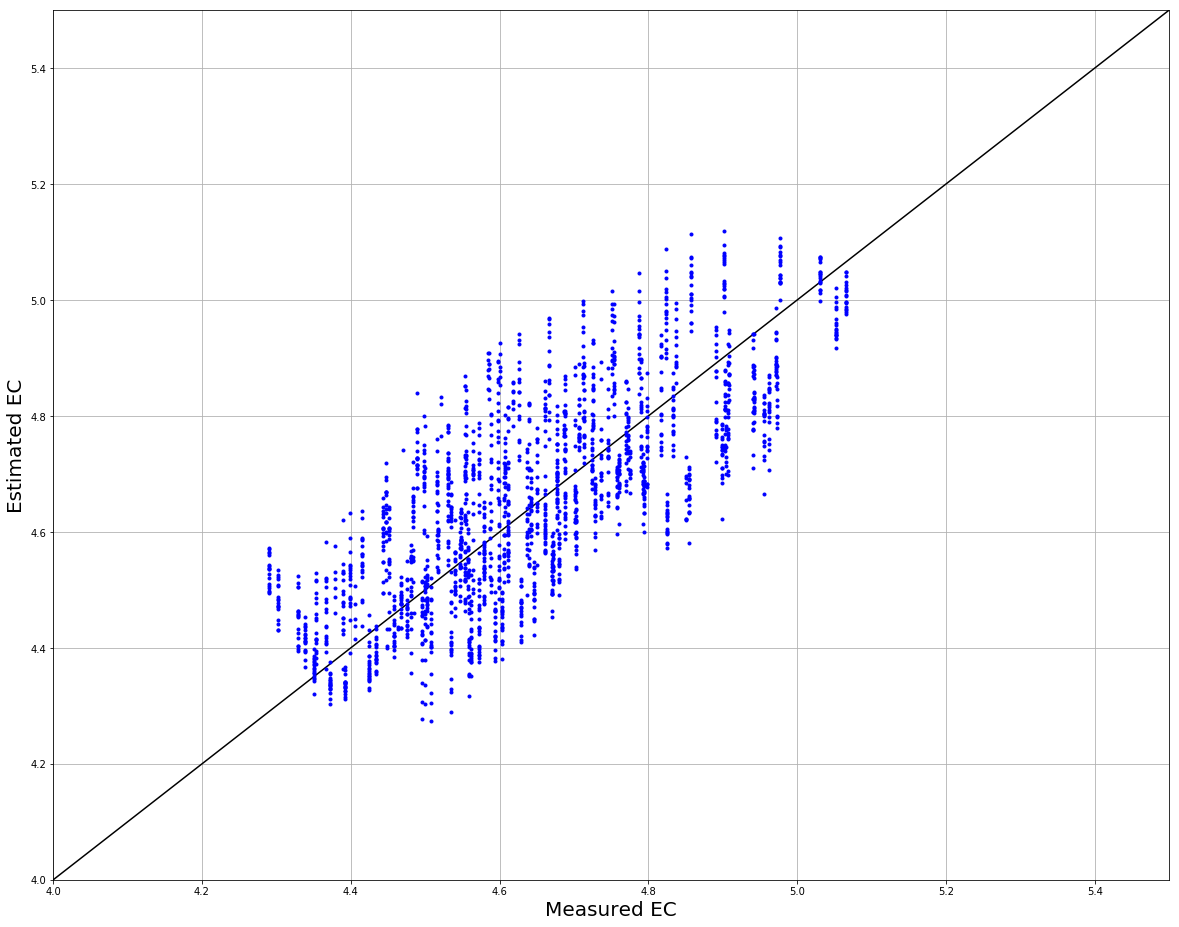

In [29]:
#1:1 graph
x_t = np.arange(-5, 15)
y_t = x_t

xny = plt.plot(x_t,y_t,'k')

expect1 = plt.plot(pred_label, prediction, 'b.')

plt.axis([4, 5.5, 4, 5.5])
plt.grid(True)
plt.xlabel('Measured EC', {'fontsize':20})
plt.ylabel('Estimated EC',  {'fontsize':20})
#plt.legend([expect1], ["Mg"], prop={'size': 12})
plt.show()

1 0.104673221134
2 0.105179440556
3 0.111588078528
4 0.107533491729
5 0.102371020626
6 0.111290503764
7 0.10487336235
8 0.102504237741
9 0.102702249583
10 0.0905491711836
11 0.0922182855528
12 0.100246473724
13 0.0950527694547
14 0.0923048171863
15 0.103265864971
16 0.111450236648
17 0.108140906278
18 0.11487581722
[0.1046732211339032, 0.10517944055627901, 0.11158807852780382, 0.10753349172874736, 0.10237102062649206, 0.11129050376397599, 0.10487336234975757, 0.10250423774083467, 0.10270224958278525, 0.090549171183550825, 0.092218285552837204, 0.10024647372422392, 0.095052769454673447, 0.092304817186284985, 0.10326586497059577, 0.11145023664757063, 0.10814090627811582, 0.11487581721976953]


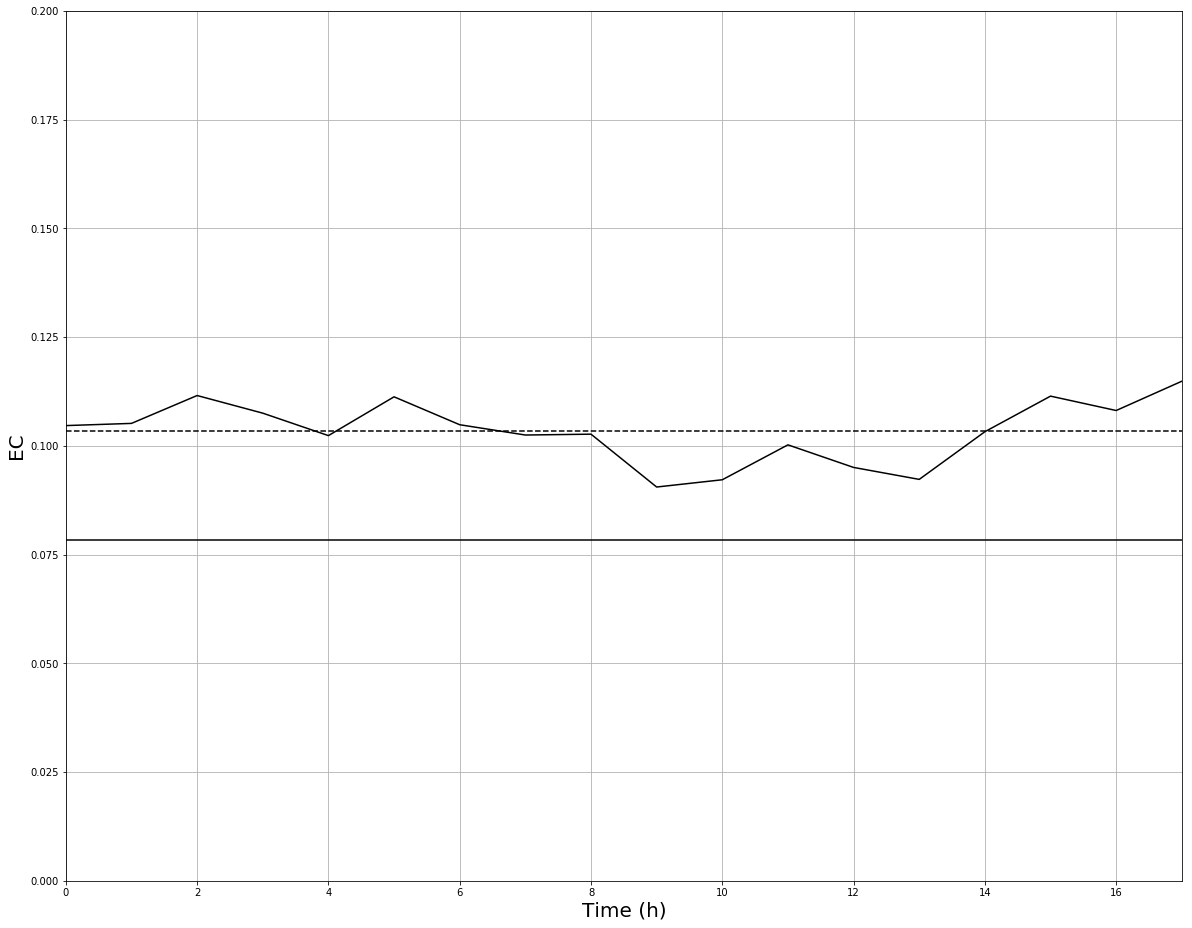

In [30]:
RMSE_data = []
for i in range(pred_label.shape[1]):
    k = np.sum(np.sqrt((pred_label[:, i] - prediction[:, i])**2))/120
    print(i+1, k)
    RMSE_data.append(k)
print(RMSE_data)


x_t = np.arange(0, 18)
y_t = x_t*0 + test_RMSE
y2_t = x_t*0 + valid_RMSE

RMSEs = plt.plot(x_t,RMSE_data, 'k')
test_RMSE = plt.plot(x_t, y_t, 'k--')
valid_RMSE = plt.plot(x_t, y2_t, 'k-')

plt.axis([0, 17, 0, 0.2])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

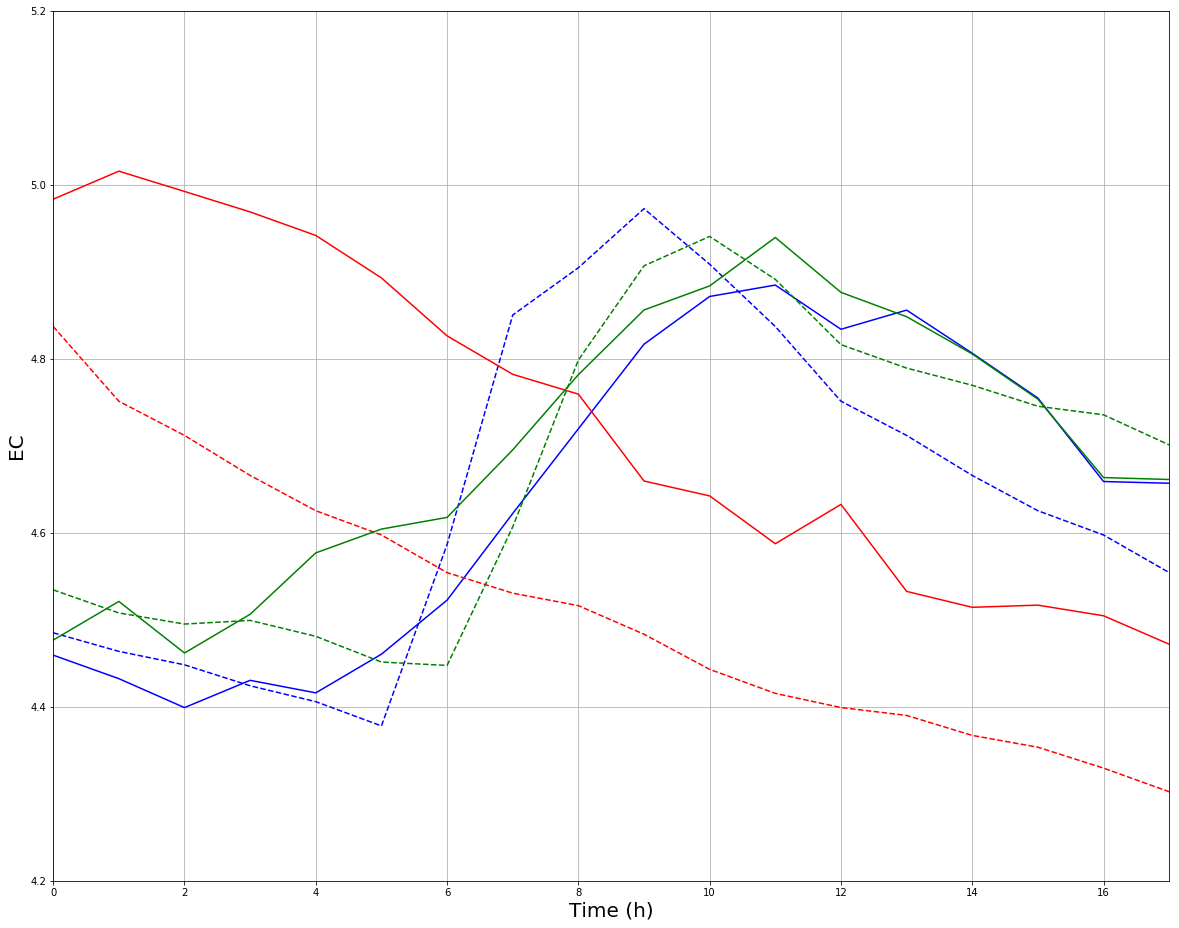

In [31]:
#chronological graph
i = 0
j = 11
k = 72
x_t = np.arange(0, 18)


expect1 = plt.plot(x_t, prediction[i,:].T, 'b') #estimated
measured1 = plt.plot(x_t, pred_label[i,:].T, 'b--') #estimated

expect2 = plt.plot(x_t, prediction[j,:].T, 'r') #estimated
measured2 = plt.plot(x_t, pred_label[j,:].T, 'r--') #estimated

expect3 = plt.plot(x_t, prediction[k,:].T, 'g') #estimated
measured3 = plt.plot(x_t, pred_label[k,:].T, 'g--') #estimated


plt.axis([0, 17, 4.2, 5.2])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

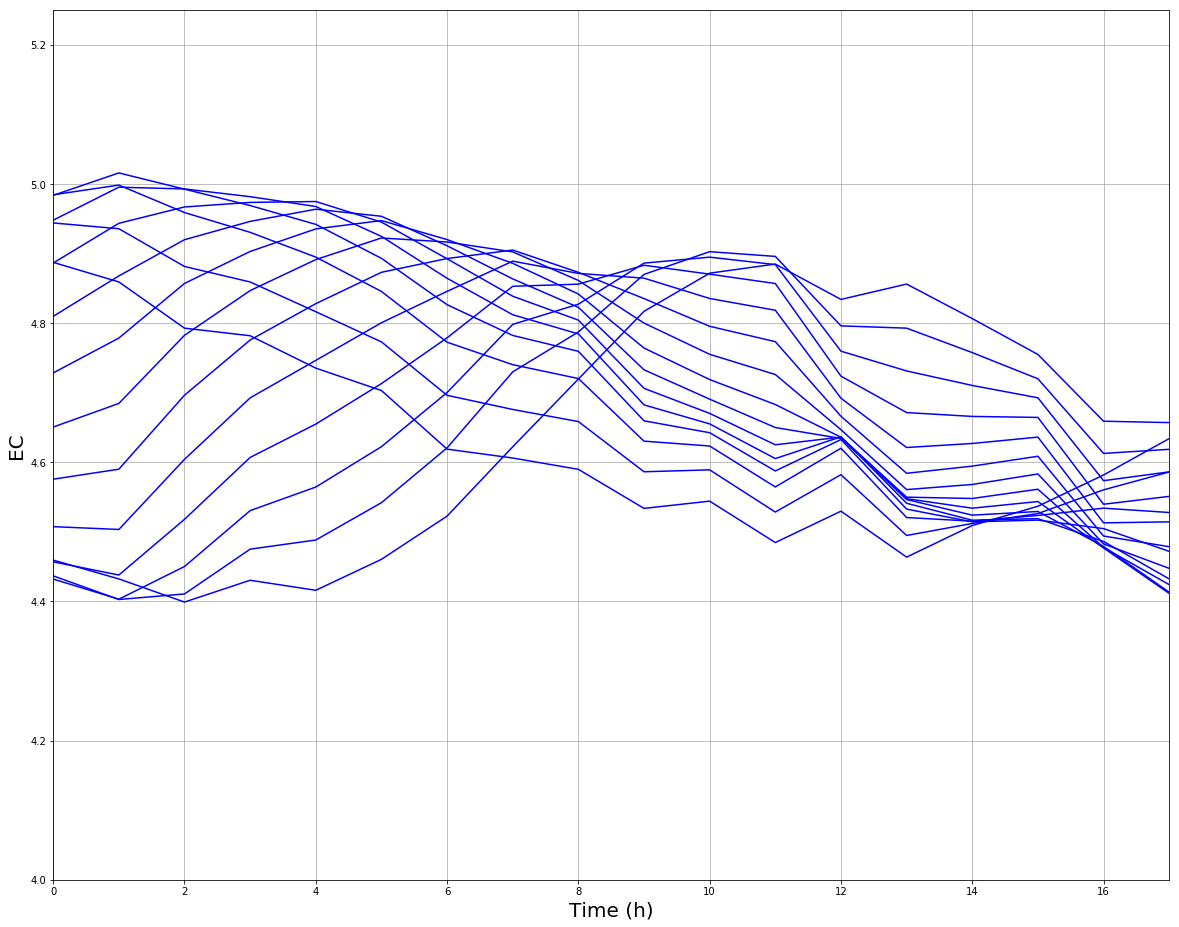

In [32]:
#chronological graph
x_t = np.arange(0, 18)

#measured1 = plt.plot(x_t, pred_label[:,:].T, 'k') #estimated
expect1 = plt.plot(x_t, prediction[:15,:].T, 'b') #estimated

plt.axis([0, 17, 4, 5.25])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

In [33]:
regression_output = np.concatenate((pred_label.T, prediction.T), axis=0).T

file_name = "pred_output_" + explanation + ".CSV"
np.savetxt("./Results/" + file_name, regression_output, delimiter=",")

In [34]:
sess.close()